In [9]:
import os
import nibabel as nib
import numpy as np
import nilearn
from nilearn import image
import pandas as pd
from hampel import hampel
import scipy.stats as stats
import matplotlib.pyplot as plt

In [10]:
# data_dir = '/arc/project/st-ipor-1/mkhademi/BOLD5000_2.0/'
# output_dir = '/scratch/st-ipor-1/mkhademi/'
output_dir = 'C:\\Users\\mahkh\\Documents\\'
roi_dir = output_dir + 'image_data\\parcels\\'
subjs = ['CSI1', 'CSI2', 'CSI3', 'CSI4']
roi_names =['lFFA','lOFA','lSTS','lLOC','lPPA','lRSC','lTOS','lEBA','rFFA','rOFA','rSTS','rLOC','rPPA','rRSC','rTOS','rEBA']
roi_voxels = {'lFFA': 531, 'rFFA': 1019, 'lOFA': 211, 'rOFA': 790, 'lSTS': 844, 'rSTS': 2505, 'lLOC': 4971, 'rLOC': 5085,
             'lPPA': 732, 'rPPA': 553, 'lRSC': 1063, 'rRSC': 1741, 'lTOS': 133, 'rTOS': 251, 'lEBA': 2155, 'rEBA': 2413}

In [11]:
sub = subjs[3]
#sub = 'all'
j = 92 # outdoor
dif = nib.load(output_dir + 'image_data\\vis\\dif-' + sub + '-c' + str(j) + '.nii.gz') 
dif = nilearn.image.resample_img(dif, target_shape=(79, 95, 69), target_affine=dif.affine)
dif = np.array(dif.dataobj)
#dif = dif[6:91-6, 7:109-7, 11:91-11]
dif_rois = []
no_roi = np.ones((79, 95, 69), dtype=np.uint8)
for roi_name in roi_names:
    roi = nib.load(roi_dir + roi_name + '.img')
    roi = np.array(roi.dataobj)
    no_roi[np.nonzero(roi)] = 0
    tmp = dif[np.nonzero(roi)]
    tmp[tmp == 0.0] = np.nan
    dif_rois.append(np.nanmedian(tmp))

In [12]:
dif_rois = np.array(dif_rois)
tmp = dif[np.nonzero(no_roi)]
tmp[tmp == 0.0] = np.nan
print('rest' + ':', np.round(np.nanmedian(tmp), 8)) 
for i, roi_name in enumerate(roi_names): 
    print(roi_name + ':', np.round(dif_rois[i], 8))

rest: -7.638e-05
lFFA: -0.0028443
lOFA: -0.00668757
lSTS: 0.00185795
lLOC: -0.00181333
lPPA: -0.00060618
lRSC: -0.00097528
lTOS: -0.00102579
lEBA: -5.947e-05
rFFA: -0.00322818
rOFA: nan
rSTS: 0.00244148
rLOC: -0.00633464
rPPA: -0.00234491
rRSC: 0.00106372
rTOS: -0.02513695
rEBA: -0.00871745


In [13]:
def get_prop(ig_type):
    igs = nib.load(output_dir + 'image_data\\vis\\' + ig_type + '-' + sub + '-c' + str(j) + '.nii.gz') 
    igs = nilearn.image.resample_img(igs, target_shape=(79, 95, 69), target_affine=igs.affine)
    igs = np.array(igs.dataobj)
    #igs = igs[6:91-6, 7:109-7, 11:91-11]

    tmp = igs.reshape(-1)
    tmp[tmp == 0.0] = np.nan
    tmp = tmp[~np.isnan(tmp)]
    p_pos = np.nanpercentile(tmp, 90)
    print("p_90", p_pos)
    n_p_pos = 0
    for x in tmp:
        if x > p_pos:
            n_p_pos += 1
    p_neg = np.nanpercentile(tmp, 10)
    print("p_10", p_neg)
    n_p_neg = 0
    for x in tmp:
        if x < p_neg:
            n_p_neg += 1

    igs_rois = []
    all_prop_pos = []
    all_prop_neg = []
    no_roi = np.ones((79, 95, 69), dtype=np.uint8)
    for roi_name in roi_names:
        roi = nib.load(roi_dir + roi_name + '.img')
        roi = np.array(roi.dataobj)
        no_roi[np.nonzero(roi)] = 0
        tmp = igs[np.nonzero(roi)].copy()
        tmp[tmp == 0.0] = np.nan
        tmp = tmp[~np.isnan(tmp)]
        igs_rois.append(np.nanmedian(tmp))
        prop = 0.0
        for x in tmp:
            if x >= p_pos:
                prop += 1
        if len(tmp) > 0:
            # all_prop_pos.append(prop/len(tmp))
            all_prop_pos.append(prop/n_p_pos)
        else:
            all_prop_pos.append(0.0)
        prop = 0.0
        for x in tmp:
            if x <= p_neg:
                prop += 1
        if len(tmp) > 0:
            # all_prop_neg.append(prop/len(tmp))
            all_prop_neg.append(prop/n_p_neg)
        else: 
            all_prop_neg.append(0.0)
    igs_rois = np.array(igs_rois)   
    tmp = igs[np.nonzero(no_roi)].copy()
    tmp[tmp == 0.0] = np.nan
    ##
    prop = 0.0
    for x in tmp:
        if x > p_pos:
            prop += 1
    # all_prop_pos.append(prop/len(tmp))
    all_prop_pos.append(prop/n_p_pos)
    ##
    print('\n')
    ##
    prop = 0.0
    for x in tmp:
        if x < p_neg:
            prop += 1
    #all_prop_neg.append(prop/len(tmp))
    all_prop_neg.append(prop/n_p_neg)
    ##
    print('\nMedian IGs:')   
    print('rest' + ':', np.round(np.nanmedian(tmp), 8))
    for i, roi_name in enumerate(roi_names): 
        print(roi_name + ':', np.round(igs_rois[i], 8))
    return all_prop_pos, all_prop_neg

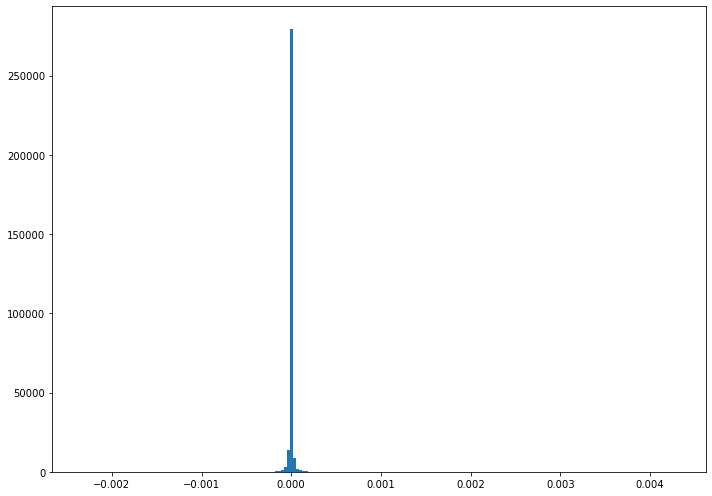

In [14]:
igs = nib.load(output_dir + 'image_data/vis/igs-' + sub + '-c' + str(j) + '.nii.gz') 
igs = nilearn.image.resample_img(igs, target_shape=(79, 95, 69), target_affine=igs.affine)
igs = np.array(igs.dataobj)
#igs = igs[6:91-6, 7:109-7, 11:91-11]

tmp = igs.reshape(-1)
tmp[tmp == 0.0] = np.nan
tmp = tmp[~np.isnan(tmp)]
fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True)
axs.hist(tmp, bins=200)
# Show plot
plt.show()

In [15]:
def plot_igs(x_yes, x_no, t, y):
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.rc('font', size=10)
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylabel(y)
    ax.set_xlabel('Brain ROIs')
    ax.set_title(sub + ': Outdoor ' + t)
    x_pos = np.arange(len(roi_names)+1)*5
    ax.bar(x_pos, x_yes, align='center', color='blue', alpha=0.8, ecolor='black', capsize=10, width=2)
    ax.bar(x_pos+2, x_no, align='center', color='red', alpha=0.8, ecolor='black', capsize=10, width=2)
    ax.set_xticks(x_pos+1)
    ax.set_xticklabels(roi_names +['Rest'])
    plt.show()

p_90 1.3696119731321234e-05
p_10 -1.245328176082694e-05



Median IGs:
rest: 0.0
lFFA: -1e-08
lOFA: -6e-08
lSTS: -2e-08
lLOC: 0.0
lPPA: 7.4e-07
lRSC: 1.55e-06
lTOS: 9.7e-07
lEBA: -6e-08
rFFA: -0.0
rOFA: -0.0
rSTS: -0.0
rLOC: -0.0
rPPA: 6e-07
rRSC: 2.4e-07
rTOS: 0.0
rEBA: -0.0
p_90 6.9134734076215e-06
p_10 -7.941024887259118e-06



Median IGs:
rest: -0.0
lFFA: 8e-08
lOFA: -9e-08
lSTS: -6e-07
lLOC: 0.0
lPPA: 4.5e-07
lRSC: 1.08e-06
lTOS: 1.04e-06
lEBA: -2e-07
rFFA: -0.0
rOFA: -0.0
rSTS: -0.0
rLOC: -0.0
rPPA: 1.9e-07
rRSC: -2.2e-07
rTOS: 0.0
rEBA: -0.0


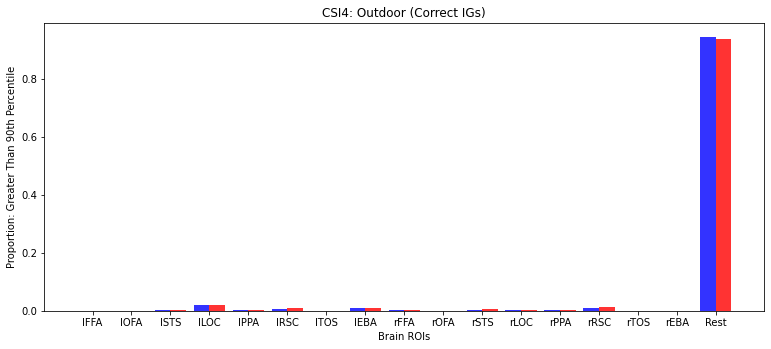

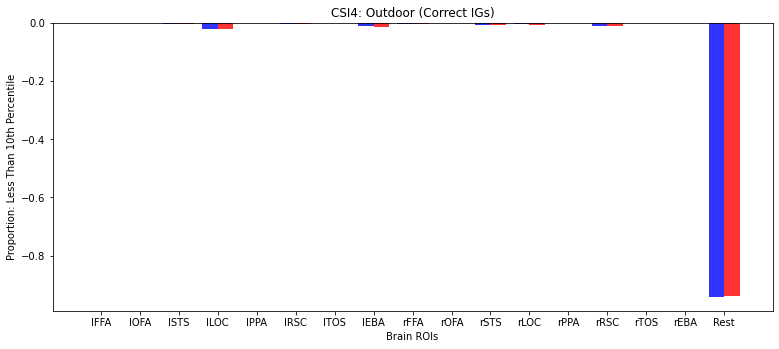

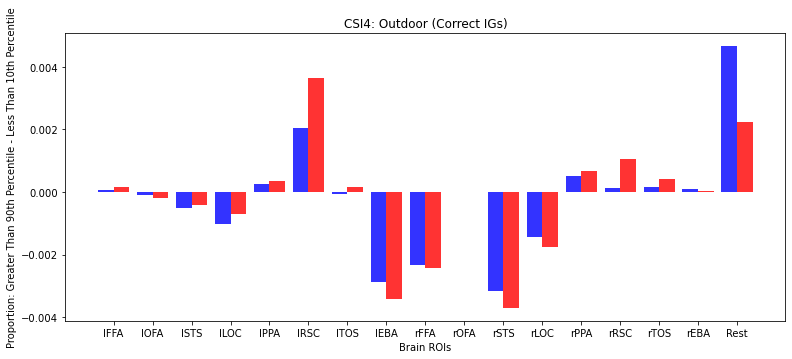

In [16]:
#all_prop_pos, all_prop_neg = get_prop(ig_type='igs')
#plot_igs(all_prop_pos, '(Correct IGs - ALL)', 'Proportion: Greater Than 90th Percentile')
#plot_igs(all_prop_neg, '(All Correct IGs)', 'Proportion: Less Than 10th Percentile')

all_prop_pos_yes, all_prop_neg_yes = get_prop(ig_type='igs-p')
all_prop_pos_no, all_prop_neg_no = get_prop(ig_type='igs-n')
plot_igs(all_prop_pos_yes, all_prop_pos_no, '(Correct IGs)', 'Proportion: Greater Than 90th Percentile')
plot_igs(-np.array(all_prop_neg_yes), -np.array(all_prop_neg_no), '(Correct IGs)', 'Proportion: Less Than 10th Percentile')
arg1 = np.array(all_prop_pos_yes)-np.array(all_prop_neg_yes)
arg2 = np.array(all_prop_pos_no)-np.array(all_prop_neg_no)
plot_igs(arg1, arg2, '(Correct IGs)', 'Proportion: Greater Than 90th Percentile - Less Than 10th Percentile')
